# BM 336546 - HW2: Type 1 Diabetes (T1D)
Our goal is to predict if a patient suffers from T1D, by applying ML algorithms on the given dataset. 


## I. Theory questions
### 1) Accuracy vs. performance scores
By definition, accuracy is the fraction of predictions our model got right. So, it seems to be a good parameter that give a good insight of the model.

Let’s take an example and calculating accuracy for the following model that classified 1000 people as having T1D (+) or not having the pathology (-):

- True positive : 10
- False positive : 10
- True negative : 900
- False negative : 80

$$Accuracy = \frac{TN+TP}{TN+FN+TP+FP}=\frac{900+10}{10+10+900+80}=\frac{91}{100}$$

That’s a good value for the accuracy parameter but if we see closer, we will remark that:
- On the 1000 people, 910 don’t have the pathology and FN+TP=90 have it.
- On the 910 healthy people, the model correctly identifies 900 as healthy.
- On the 90 people who have the pathology, the model correctly identifies 10. That’s mean that 80 people (on 90) are undiagnosed! 

So, at first glance, accuracy seems to be a good parameter (by its definition) and having a high value of accuracy seems important but, in fact, it is not sufficient to have a good insight of a data. 

$$Sensitivity = \frac{TP}{FN+TP}=\frac{10}{10+80}=\frac{1}{9}$$

In this case, calculating sensibility will have tell us how much the model is bad at predicting correctly the pathology.

$$F_1\space score = 2*\frac{PPV*Se}{PPV+Se}=\frac{2}{11}$$

F1 score is a measure of the trade-off between SE and PPV and will give us insight about the precision and the robustness of the model.

So **model performance scores (sensitivity, specificity, positive predictive value, negative predictive value, F1…) are more important to have a good insight of the model.**

### 2) Two vs. all features
Let’s study the pros and cons of the given models:  

*“the first uses only BP and BMI features”*

**The pros**
>- Avoid the curse of dimensionality: a low dimensionality allows an easier interpretability of the data, smaller computation complexities, and avoids redundancy.
>- Shorter training time: less calculations to make.
>- Easier to analyse and interpret: a two dimensional dataset is easier to represent and analyse for a human eye.  

**The cons**
>- Lack of data: too few features in a dataset is not complex enough to make predictions; having more features allows to be more precise / some features can be more relevant in the whole dataset than just the two of them. 
>- Can lead to wrong conclusions: if the specific features are not very representative for our problem, building models according to the two features can lead to wrong predictions.

*“the other one uses all of the features available”*

**The pros**
>- No lack of data: we use all the information/parameters available for each patient, therefore we can better fit our problem to the population in it. 
>- Higher dimensionality can improve the diagnostic, as more data is added, therefore can lead to new correlations/better results

**The cons**
>- Curse of dimensionality: leading to high computational time complexity and difficulty to interpret the dataset.
>- Some features can be redundant.


### 3) Logistic regression vs. linear SVM vs. non-linear SVM

If we suppose that the data won’t be easily linearly separable, linear models probably won’t be a good approach and we will prefer Non-Linear SVM. 

Also, depending on the data that we have (number of rows / feature), we can choose to use either logistic regression or support vector machine.

- If the number of features is large and number of samples is small: we would rather use logistic regression or SVM with a linear kernel, fastest for computations (in particular logistic regression). To better handle overfitting problems, linear SVM performs better since it uses a geometric rather than probabilistic approach.
- If the number of features is small and the number of samples is intermediate: we would rather use SVM with a non-linear kernel (Gaussian, polynomial …), which can make predictions more accurate due to a higher complexity of the model.

According to the given information *difficult to distinguish them from the human eye, or by just looking at the features* we can suppose that the data is not linearly separable, and from *dozens of parameters* we understand we have a small number of features, therefore we would choose the non-linear model: **non-linear SVM**.


### 4) Logistic regression vs. linear SVM

While Logistic regression (LR) uses a statistical and probabilistic approach (that way, it works well for already identified independent variables, and for lower amount of features studied), linear SVM uses a more geometric one (that way, works better with unstructured data in general such as biopsies…). 

LR focuses on maximizing the probability of the data in order to find the correct decision boundary. It is more efficient on low dimensional space.

Hyperparameters of Logistic regression:

- Regularization (L1/L2) – sort of penalty- imposes a cost on the optimization function for overfitting the function or to find an optimal solution.
- C (inverse of regularization term), controls the importance we give to the weight coefficients of the regression. A higher regularization term means we want to penalize high coefficients (to avoid overfitting or taking into account noises). Its choice will regularize the underfitting/overfitting problem by regularizing the bias-variance tradeoff. 

SVM focuses on maximizing the margins, the distance that separates the hyperplane from the support vectors (tends to reduce the risk of misclassifications). It is more efficient on high dimensional space.
Hyperparameters of SVM:

- C is the regularization term, showing how much we are willing to let the algorithm make mistakes (inside / on the other side of the margins). It controls the trade-off between maximize margin/allow misclassification. Its choice will be efficient in order to reduce the risks of overfitting/underfitting the data. The higher is C, the more we allow mistakes in the classification. 

We can notice that, even if their approach is different, the hyperparameters aim to fill a same goal (avoid overfitting and underfitting). 



## II. Practical part
### 1) Loading the data

Let's start the assignment by loading the data and explain any preprocessing.

Loading the data:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
%reload_ext autoreload

file = Path.cwd().joinpath('HW2_data.csv') # concatenates HW2_data.csv to the current folder
T1D_dataset = pd.read_csv(file) # load the data
random.seed(10)  # fill your seed number here
print('hello')
T1D_dataset

hello


,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,Male,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,Negative,0
1,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative,0
2,45,Male,Yes,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,Yes,No,Positive,0
3,59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,1
4,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Positive,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,54,Male,Yes,Yes,Yes,Yes,No,NaN,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Positive,0
561,32,Male,No,No,No,No,No,NaN,No,No,Yes,Yes,No,No,No,Yes,Positive,0
562,61,Female,Yes,No,No,No,Yes,No,No,No,Yes,No,No,No,Yes,No,Positive,1
563,46,Male,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,Yes,No,Negative,0


Now we can apply some preprocessing. We decided to fill the empty cells (nan) with random values from each column, in order to be able to interpret all the lines all the dataset. Due to the binary nature of our dataset, filling nans with random values from the dataset is more appropriate than any metrics (median,...) of the features. Also, we could have thought about erasing the rows (patients) with any nan, but due to the high number of such rows, we decided to choose an imputation method. 

In [2]:
from helpers_function import nan2rand_val as rv

filled_dataset = rv(T1D_dataset)
filled_dataset

,Age,Gender,Increased Urination,Increased Thirst,Sudden Weight Loss,Weakness,Increased Hunger,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Hair Loss,Obesity,Diagnosis,Family History
0,45,Male,No,No,No,Yes,No,No,No,Yes,No,No,Yes,No,Yes,No,Negative,0
1,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,Negative,0
2,45,Male,Yes,Yes,No,Yes,No,Yes,No,No,No,Yes,No,No,Yes,No,Positive,0
3,59,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,1
4,40,Female,Yes,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Positive,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,54,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Positive,0
561,32,Male,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,Yes,Positive,0
562,61,Female,Yes,No,No,No,Yes,No,No,No,Yes,No,No,No,Yes,No,Positive,1
563,46,Male,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,Yes,No,Negative,0


### 2) Splitting the data


Now we will split our dataset into a train (80%) and test (20%) sets, using the sklearn function. We would like our sets to represent equally the classes (diagnosis yes or no) of the patients, therefore we will use the stratify method with the diagnosis column.

In [3]:
from sklearn.model_selection import train_test_split
X = filled_dataset.loc[:, 'Age':'Obesity']
X['Family History']=filled_dataset[['Family History']]
list_features = list(X.columns.values)

Y = T1D_dataset[['Diagnosis']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)

### 3) Visualizating the data

#### a. Repartition in test/train
First, let's plot a table showing the repartition of positive features (as the features have a binary result) in each set (train and test)

In [4]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=FutureWarning)
fts = list_features.copy()
del fts[0]
partition_ft = pd.DataFrame(columns=['Positive Feature','% in train','% in test','difference'])

partition_ft['Positive Feature'] = fts
train_lst = []
test_lst = []
for ft in fts:
    pos_ft_train = np.sum(X_train[[ft]]=='Yes') + np.sum(X_train[[ft]]==1) + np.sum(X_train[[ft]]=='Male')
    train_lst.append(100*pos_ft_train/len(X_train[[ft]]))
    pos_ft_test = np.sum(X_test[[ft]]=='Yes') + np.sum(X_test[[ft]]==1) + np.sum(X_test[[ft]]=='Male')
    test_lst.append(100*pos_ft_test/len(X_test[[ft]]))
partition_ft[['% in train']] = train_lst
partition_ft[['% in test']] = test_lst
partition_ft[['difference']] = np.array(train_lst) - np.array(test_lst)
partition_ft

,Positive Feature,% in train,% in test,difference
0,Gender,63.7168,63.7168,0
1,Increased Urination,49.5575,43.3628,6.19469
2,Increased Thirst,45.7965,40.708,5.0885
3,Sudden Weight Loss,42.4779,32.7434,9.73451
4,Weakness,58.4071,52.2124,6.19469
5,Increased Hunger,44.469,45.1327,-0.663717
6,Genital Thrush,21.2389,24.7788,-3.53982
7,Visual Blurring,44.2478,47.7876,-3.53982
8,Itching,50.885,39.823,11.0619
9,Irritability,23.8938,22.1239,1.76991


As we can notice, the difference between the percentage of positive features in the train and in the test set is lower than 10% (in absolute value). Hence, we can conclude that the data is distributed similarly in both sets (train and test).

An imbalance of features between train and test sets could cause a bad interpretation of the dataset; if in the train set, we have a lot more positive values ('Yes') for a specific feature, the model trained on it will be fitted accordingly (will be very accurate for that positive feature), but not taking in consideration the negative values ('No'), that we will surely interpret wrongly in the test set. Also, having an imbalanced dataset will force us to reduce the performance metrics relevant for the problem (accuracy is not relevant in that case, we will prefer measure the performances of the models with f1, Area Under the ROC,...).

In order to solve such an issue, we can for example split the dataset again. If the amount of features is quite small, we can split using the ratio 80/20% while selecting the data according to the imbalanced represented feature and the diagnosis (we want to be balanced as well). Another idea may be collect more data to include in our dataset, in order to increase the chance to have more balance between the features themselves in the sets, and also a good balance for the diagnosis in both sets (which can be obtain using stratification).

#### b. Relationship between features and label

We will now plot the relationship between features and label:

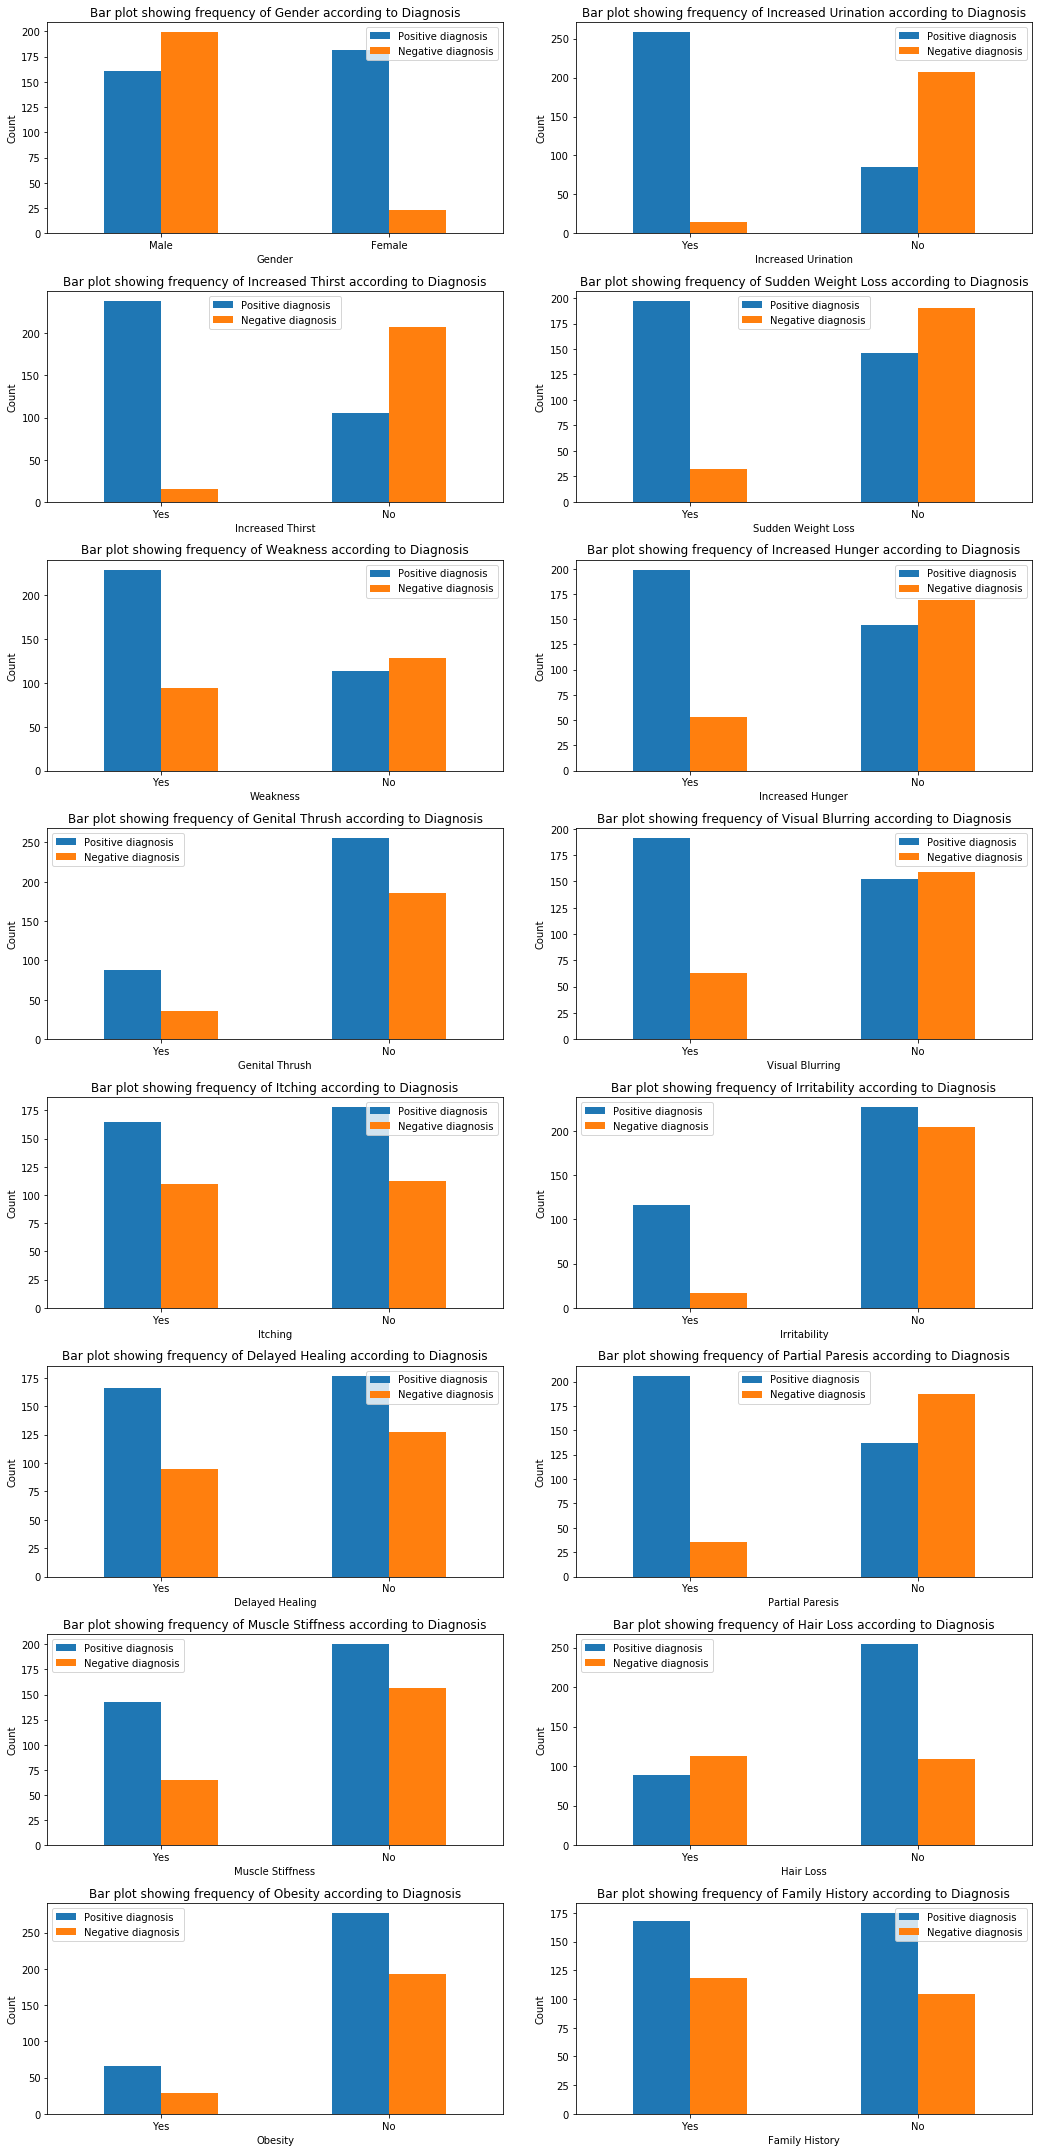

In [5]:
fts = ['Increased Thirst', 'Increased Urination', 'Muscle Stiffness', 'Obesity']
fts = ['Gender', 'Increased Urination', 'Increased Thirst', 'Sudden Weight Loss', 'Weakness', 'Increased Hunger', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Hair Loss', 'Obesity', 'Family History']
figure, axes = plt.subplots(nrows=8, ncols=2, figsize=[15,30])
i=j=0
for ft in fts:
    ax = axes[i, j]
    DiagYesFt = filled_dataset[ft].loc[filled_dataset['Diagnosis'] == 'Positive']
    if ft=='Gender':
        DiagYesFtYes = np.sum(DiagYesFt == 'Male')
        DiagYesFtNo = np.sum(DiagYesFt == 'Female')
    elif ft=='Family History':
        DiagYesFtYes = np.sum(DiagYesFt == 1)
        DiagYesFtNo = np.sum(DiagYesFt == 0)
    else:
        DiagYesFtYes = np.sum(DiagYesFt == 'Yes')
        DiagYesFtNo = np.sum(DiagYesFt == 'No')

    DiagNoFt = filled_dataset[ft].loc[filled_dataset['Diagnosis'] == 'Negative']
    if ft=='Gender':
        DiagNoFtYes = np.sum(DiagNoFt == 'Male')
        DiagNoFtNo = np.sum(DiagNoFt == 'Female')
    elif ft=='Family History':
        DiagNoFtYes = np.sum(DiagNoFt == 1)
        DiagNoFtNo = np.sum(DiagNoFt == 0)
    else:
        DiagNoFtYes = np.sum(DiagNoFt == 'Yes')
        DiagNoFtNo = np.sum(DiagNoFt == 'No')
    
    DiagYes = [DiagYesFtYes, DiagYesFtNo]
    DiagNo = [DiagNoFtYes, DiagNoFtNo]
    if ft=='Gender':
        index = ['Male','Female']
    else:
        index = ['Yes','No']
    df = pd.DataFrame({'Positive diagnosis': DiagYes,
                       'Negative diagnosis': DiagNo}, index=index)
    df.plot.bar(ax=axes[i, j],rot=0)
    axes[i, j].set_xlabel(ft)
    axes[i, j].set_ylabel('Count')
    axes[i, j].set_title(f'Bar plot showing frequency of {ft} according to Diagnosis')
    
    if j<1:
        j+=1
    elif i<8:
        i+=1
        j=0
    else:
        break
        
figure.tight_layout()
plt.show()

As we can see, we have some features ('Increase Thrist', 'Increased Urination') which are very discriminative; for a 'Yes' answer from the patient, we have a great chance to be having Type 1 Diabetes, and a good chance of not having it for a 'No' answer (with a greatest discriminability for the 'Yes' answer). Meaning the features form a good correlation with the diagnosis 

On the opposite, in some features ('Obesity', 'Muscle Stiffness', 'Family History'), an answer 'Yes' or 'No' leads in both case to have a greater probability to have a positive diagnosis, therefore they do not seem helpful for the classification.

A surprising result is 'Family History' not being a good feature, as we could have thought genetics is a significative factor of the disease.

#### c. Age distribution

Now let's plot an histogram of ages to see the distribution of ages in our dataset

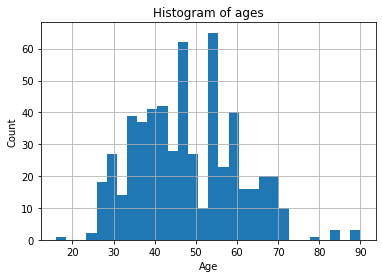

In [6]:
feat = 'Age'

filled_dataset[feat].hist(bins=30)
plt.title('Histogram of ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

As we can see, the ages distribution has a Gaussian shape, with a peak around 55 years (the most represented age group). Meaning we have a lot more data from people in their 50s than in their 20s or 80s. This is to take in consideration, the dataset is adequate for people in a specific age range and might not be very accurate with a people with under-represented age.

#### d. Age distribution according to the diagnosis

Now, let's plot the age distributions for sick and non sick patients independantly (in an histogram, to look at the counts and a boxplot to look at the distributions):

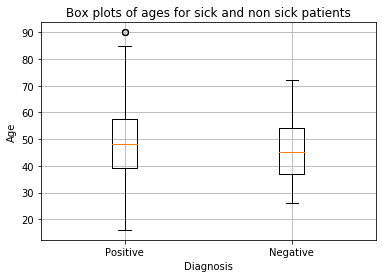

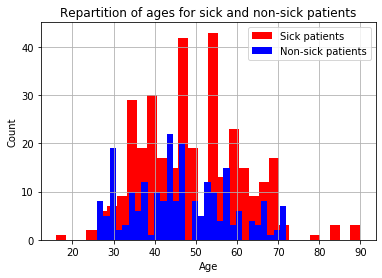

In [7]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
feat = 'Age'
Pos_dataset = filled_dataset[filled_dataset['Diagnosis']=='Positive']
Neg_dataset = filled_dataset[filled_dataset['Diagnosis']=='Negative']

fig1, ax1 = plt.subplots()

data = [np.asarray(Pos_dataset[feat], dtype=int), np.asarray(Neg_dataset[feat], dtype=int)]

ax1.boxplot(data)
ax1.set_xticklabels(['Positive', 'Negative'])
ax1.set_title('Box plots of ages for sick and non sick patients')
ax1.set_xlabel('Diagnosis')
ax1.set_ylabel('Age')
plt.grid()
plt.show()

Pos_dataset[feat].hist(bins=30, color='r', label='Sick patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

Neg_dataset = filled_dataset[filled_dataset['Diagnosis']=='Negative']
Neg_dataset[feat].hist(bins=30, color='b', label='Non-sick patients')
plt.xlabel('Age')
plt.ylabel('Count')

plt.legend()
plt.title('Repartition of ages for sick and non-sick patients')
plt.show()

As we can notice, the distribution of sick and non sick patients according to their ages is significative; the sick patients represent a group of age older than the non-sick patients, as well as a different distribution, therefore it adds information about the probability of having the illness.

#### e. Correlations between all the features

Now let's plot a heatmap representing the correlations between the features:

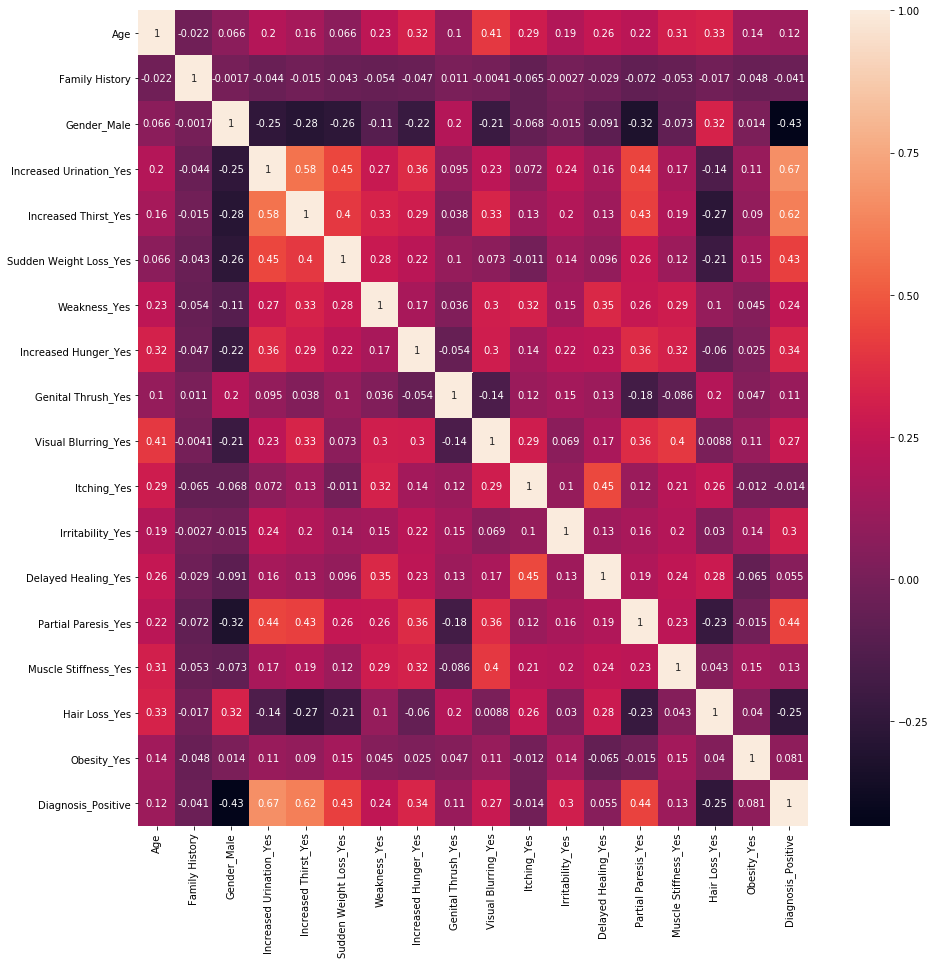

In [8]:
import seaborn as sns
dummyData = pd.get_dummies(filled_dataset, drop_first=True)
plt.figure(figsize = (15,15))
sns.heatmap(dummyData.iloc[:,:].corr(), annot = True)
plt.show()

As we can notice, some features have a great correlation with the diagnosis ('Increased Urination', 'Increased Thirst',...), giving an indication they might be very relevant for the prediction; others show correlations between themselves ('Increased Urination' and 'Increased Thirst', 'Increased Urination' and 'Sudden Weight Loss'), showing they might be redundant in the dataset.

### 4) Encoding the data as one hot vectors 

We will now transform the dataset into one hot vectors, in order to make it interpretable for the machine learning algorithms used later:

In [9]:
bin_Xtrain = pd.get_dummies(X_train, drop_first=True)
bin_Xtest = pd.get_dummies(X_test, drop_first=True)
bin_ytrain = pd.get_dummies(y_train, drop_first=True)
bin_ytest = pd.get_dummies(y_test, drop_first=True)

### 5) 5K Cross Fold Validation and evaluation of three models

Let's start by doing a 5K cross fold validation. 

In this section, we want to train one linear model (we chose logistic regression) and two non-linear models (we chose random forest and non-linear SVM), tuning their ideal parameters with a 5K cross fold validation using their ROC AUC, and reporting their performance scores on the test set.

We start by tuning the logistic regression model:

In [10]:
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, f1_score

import warnings
from helpers_function import tune_LogReg, tune_RandForest

kf = SKFold(n_splits=5)
best_params_LR = tune_LogReg(kf, bin_Xtrain, bin_ytrain)
print('The best parameters tuned are: ',best_params_LR)

The best parameters tuned are:  {'C': 100.0, 'penalty': 'l1', 'auc_score': 0.9579220779220778}


Let's report the performance score on the test set using the tuned parameters:

In [30]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from helpers_function import report_performance

clf = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(bin_Xtrain,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test',
           'Non-linear SVM, on train', 'Non-linear SVM, on test']
df_scores = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores.loc['Logistic Regression, on train'] = report_performance(clf,bin_Xtrain, bin_ytrain)
df_scores.loc['Logistic Regression, on test'] = report_performance(clf,bin_Xtest, bin_ytest)

df_scores.head(2)

,F1 score,Accuracy,ROC AUC,Log loss
"Logistic Regression, on train",0.936803,0.924779,0.975457,1.91869
"Logistic Regression, on test",0.924242,0.911504,0.977602,2.60887


Let's print the confusion matrices for train and test sets:

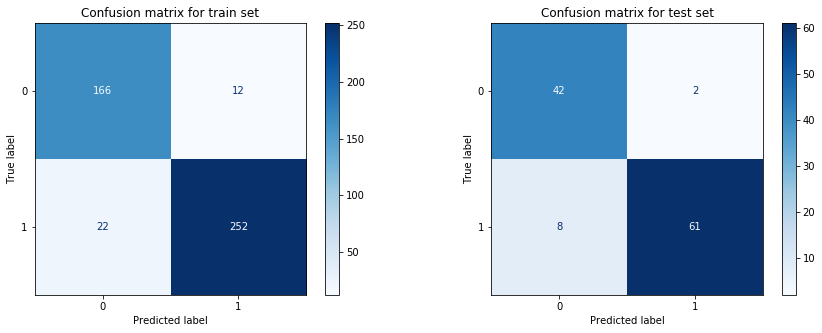

In [12]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf, bin_Xtrain, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf, bin_Xtest, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Let's see if we can do better with non-linear models.

Let's tune the Random forest model:

In [13]:
from sklearn.ensemble import RandomForestClassifier
best_params_RF = tune_RandForest(kf, bin_Xtrain, bin_ytrain)

print(best_params_RF)

{'Nb_trees': 10, 'Criterion': 'entropy', 'Max_features': 3, 'oob_score': False, 'auc_score': 0.9974747474747475}


Let's report the performance score on the train and test sets using the tuned parameters:

In [14]:
clf_RF = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=best_params_RF['Max_features'], 
                             oob_score=best_params_RF['oob_score']).fit(bin_Xtrain,bin_ytrain)

df_scores.loc['Random Forest, on train'] = report_performance(clf_RF,bin_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Random Forest, on test'] = report_performance(clf_RF,bin_Xtest, bin_ytest, type_decision='predict_proba')

df_scores.iloc[2:4]

,F1 score,Accuracy,ROC AUC,Log loss
"Random Forest, on train",1,1,1,0.0294259
"Random Forest, on test",0.985294,0.982301,1,0.0781713


Let's print the confusion matrices for train and test sets:

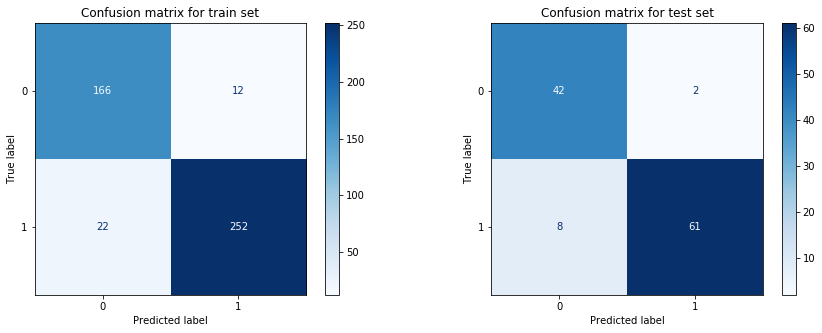

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf, bin_Xtrain, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf, bin_Xtest, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Let's check another non-linear model (non-linear SVM), using the sklearn methods of grid search to tune the parameters:

In [16]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
svc = SVC(probability=True)
C = np.logspace(-1,3,5)

pipe = Pipeline(steps=[('svm', svc)])
svm_nonlin = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly'],
                                                      'svm__gamma': ['auto', 'scale']}, cv=kf, refit='roc_auc')
svm_nonlin.fit(bin_Xtrain, bin_ytrain)
best_svm_nonlin = svm_nonlin.best_estimator_
print(svm_nonlin.best_params_)

{'svm__C': 1000.0, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}


Let's report the performance scores on the train and test sets using the tuned parameters:

In [17]:
from sklearn.metrics import accuracy_score, f1_score

df_scores.loc['Non-linear SVM, on train'] = report_performance(best_svm_nonlin, bin_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Non-linear SVM, on test'] = report_performance(best_svm_nonlin, bin_Xtest, bin_ytest, type_decision='predict_proba')

df_scores.iloc[4:6]

,F1 score,Accuracy,ROC AUC,Log loss
"Non-linear SVM, on train",1,1,1,0.032543
"Non-linear SVM, on test",0.970149,0.964602,0.991436,0.129399


Let's print the confusion matrices for train and test sets:

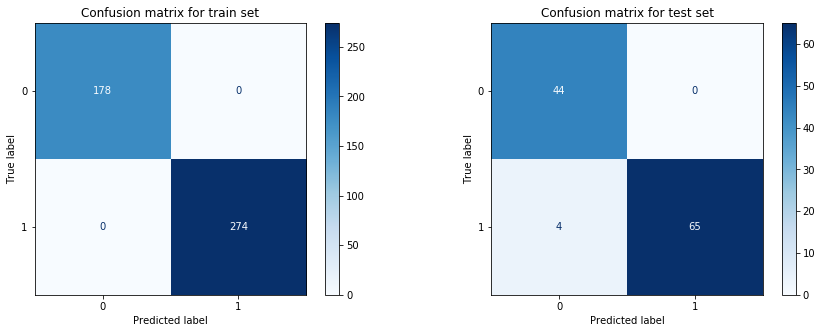

In [18]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(best_svm_nonlin, bin_Xtrain, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(best_svm_nonlin, bin_Xtest, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Let's print the ROC curves for all the classifiers tested for train and test sets:

<Figure size 432x288 with 0 Axes>

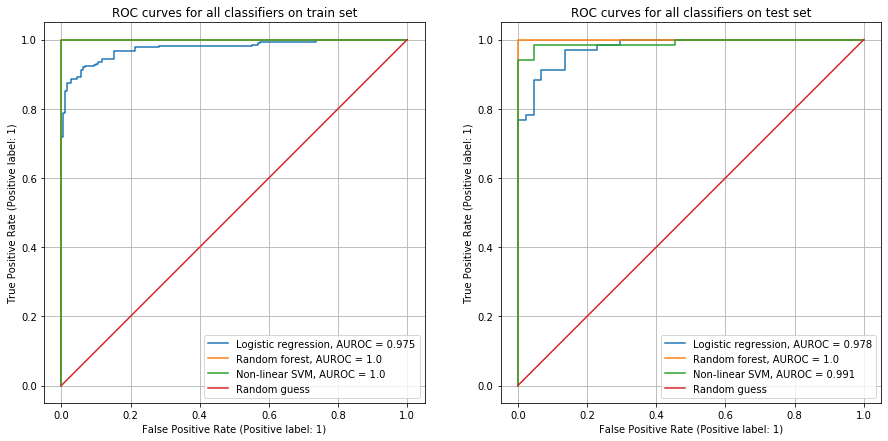

In [61]:
from sklearn.metrics import plot_roc_curve

classifiers = [clf, clf_RF,best_svm_nonlin]
roc_score = []
plt.figure()
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
for clfr in classifiers:
    plot_roc_curve(clfr, bin_Xtrain, bin_ytrain, ax=ax[0])
    roc_score.append(np.round_(roc_auc_score(bin_ytrain, clfr.predict_proba(bin_Xtrain)[:,1]), decimals=3))
ax[0].plot(np.linspace(0,1,bin_Xtrain.shape[0]),np.linspace(0,1,bin_Xtrain.shape[0]))
ax[0].legend(('Logistic regression, AUROC = '+str(roc_score[0]),'Random forest, AUROC = '+str(roc_score[1]),'Non-linear SVM, AUROC = '+str(roc_score[2]), 'Random guess'))
ax[0].grid()
ax[0].set_title('ROC curves for all classifiers on train set')

roc_score = []
for clfr in classifiers:
    plot_roc_curve(clfr, bin_Xtest, bin_ytest, ax=ax[1])
    roc_score.append(np.round_(roc_auc_score(bin_ytest, clfr.predict_proba(bin_Xtest)[:,1]), decimals=3))
ax[1].plot(np.linspace(0,1,bin_Xtest.shape[0]),np.linspace(0,1,bin_Xtest.shape[0]))
ax[1].legend(('Logistic regression, AUROC = '+str(roc_score[0]),'Random forest, AUROC = '+str(roc_score[1]),'Non-linear SVM, AUROC = '+str(roc_score[2]), 'Random guess'))
ax[1].grid()
ax[1].set_title('ROC curves for all classifiers on test set')

plt.show()

As we can notice, a non-linear model seems to fit better to our problem. All the performance scores are better using Random forest.

### 6) Feature selection

Now, we would like to use our random forest model in order to find the two most important features of our dataset:

The first most important feature is Increased Urination_Yes
The second most important feature is Increased Thirst_Yes


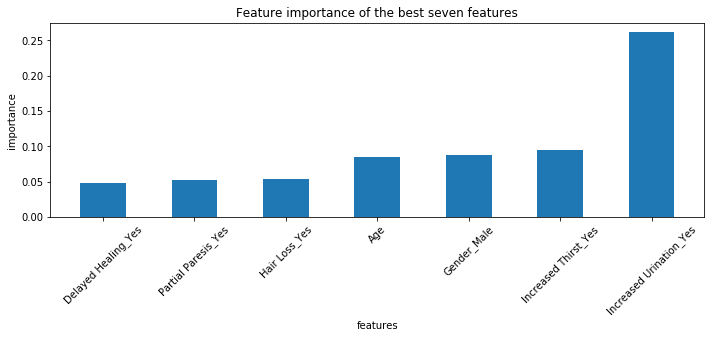

In [19]:
from  matplotlib import pyplot as plt
importance = clf_RF.feature_importances_

df_pvals_labels = list(bin_Xtrain.columns.values)

sorted_labels = [x for _,x in sorted(zip(importance,df_pvals_labels))]

sorted_imp = sorted(importance)

sorted_labels_best = sorted_labels[10:]
sorted_imp_best = sorted_imp[10:]
Imp_ft1 = sorted_labels[len(sorted_labels)-1]
Imp_ft2 = sorted_labels[len(sorted_labels)-2]
print(f'The first most important feature is {Imp_ft1}')
print(f'The second most important feature is {Imp_ft2}')
fig = plt.figure(figsize=[10, 4.8])
ax = fig.add_subplot(111)
rects1 = ax.bar([x for x in range(len(importance[10:]))], sorted_imp_best,
                     align='center', tick_label=sorted_labels_best, width=0.5)
ax.set_xticklabels(sorted_labels_best, rotation=45 )
ax.set_title('Feature importance of the best seven features')
ax.set_xlabel('features')
ax.set_ylabel('importance')


plt.tight_layout()

plt.show()

In the graph above, we plotted the feature importance using random forest of the seven best features; the two best are 'Increased Urination_Yes' and 'Increased Thirst_Yes', which is in adequation with the data exploration we did in the section 2 (we saw that those specific features were very significative for the diagnosis).

Let's look at the less important features:

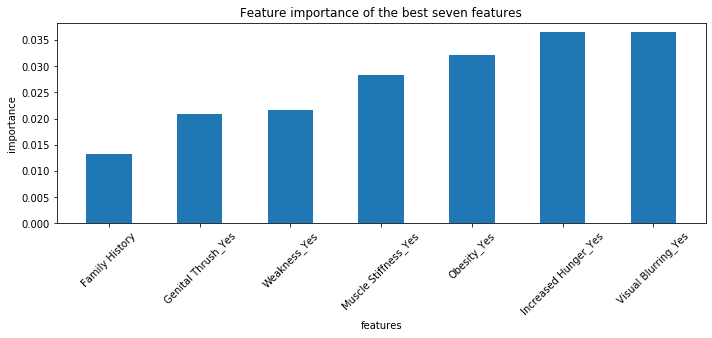

In [20]:
sorted_labels_worst = sorted_labels[:7]
sorted_imp_worst = sorted_imp[:7]

fig = plt.figure(figsize=[10, 4.8])
ax = fig.add_subplot(111)
rects1 = ax.bar([x for x in range(len(importance[:7]))], sorted_imp_worst,
                     align='center', tick_label=sorted_labels_worst, width=0.5)
ax.set_xticklabels(sorted_labels_worst, rotation=45 )
ax.set_title('Feature importance of the best seven features')
ax.set_xlabel('features')
ax.set_ylabel('importance')


plt.tight_layout()

plt.show()

In the graph above, we plotted the feature importance using random forest of the seven worst features; as seen in the data exploration, those were the features ('Family History', 'Obesity') for which we predicted a low importance according to the diagnosis. Therefore those results correspond to the data exploration done earlier.

### 7) Data Separability Visualization

Now we would like to apply a dimensionality reduction on the dataset:

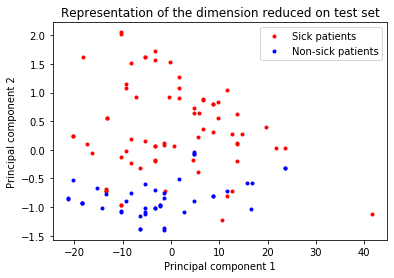

In [21]:
from sklearn.decomposition import PCA, SparsePCA, MiniBatchSparsePCA, IncrementalPCA

Dim_red = PCA(n_components=2)
Dim_red.fit_transform(bin_Xtrain)
comp_train = Dim_red.fit_transform(bin_Xtrain).T
comp_test = Dim_red.transform(bin_Xtest).T
y_test = bin_ytest
pc1 = comp_test[0]
pc2 = comp_test[1]
plt.plot(pc1[np.where(y_test==1)[0]],pc2[np.where(y_test==1)[0]], '.', color='r', label="Sick patients")
plt.plot(pc1[np.where(y_test==0)[0]],pc2[np.where(y_test==0)[0]], '.', color='b', label="Non-sick patients")
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title('Representation of the dimension reduced on test set')
plt.legend()
plt.show()

We can see that the data is not really separable; this is due to the fact that PCA does not perform well on binary data, which is not the best option to perform dimension reduction here. But, we can still see two spaces where each diagnosis (Positive or Negative) is mostly represented, with errors on each side. 

Let's find the performances of the models chosen earlier on the two first principal components.

We will start with Logistic regression:

In [63]:
new_Xtrain = comp_train.T
new_Xtest = comp_test.T
clf_LR = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(new_Xtrain,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test',
           'Non-linear SVM, on train','Non-linear SVM, on test']
df_scores = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores.loc['Logistic Regression, on train'] = report_performance(clf_LR,new_Xtrain, bin_ytrain)
df_scores.loc['Logistic Regression, on test'] = report_performance(clf_LR,new_Xtest, bin_ytest)
df_scores.head(2)

,F1 score,Accuracy,ROC AUC,Log loss
"Logistic Regression, on train",0.852273,0.827434,0.92346,4.1262
"Logistic Regression, on test",0.861538,0.840708,0.924242,4.08418


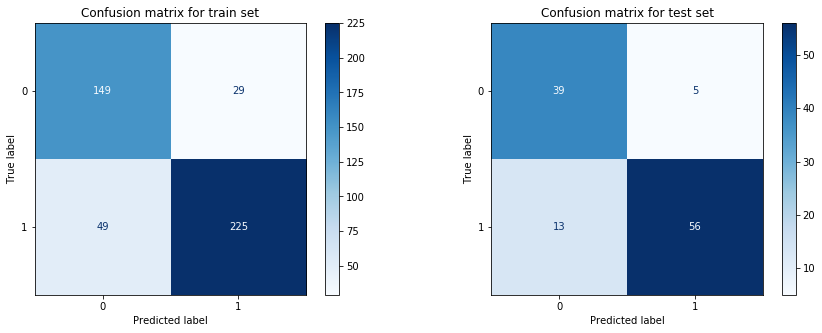

In [71]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf_LR, new_Xtrain, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf_LR, new_Xtest, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Now let's observe the performance with Random forest:

In [64]:
clf_RF_pca = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=2, 
                             oob_score=best_params_RF['oob_score']).fit(new_Xtrain,bin_ytrain)

df_scores.loc['Random Forest, on train'] = report_performance(clf_RF_pca,new_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Random Forest, on test'] = report_performance(clf_RF_pca,new_Xtest, bin_ytest, type_decision='predict_proba')
df_scores.iloc[2:4]

,F1 score,Accuracy,ROC AUC,Log loss
"Random Forest, on train",0.990826,0.988938,0.999703,0.0540011
"Random Forest, on test",0.890511,0.867257,0.936594,1.40239


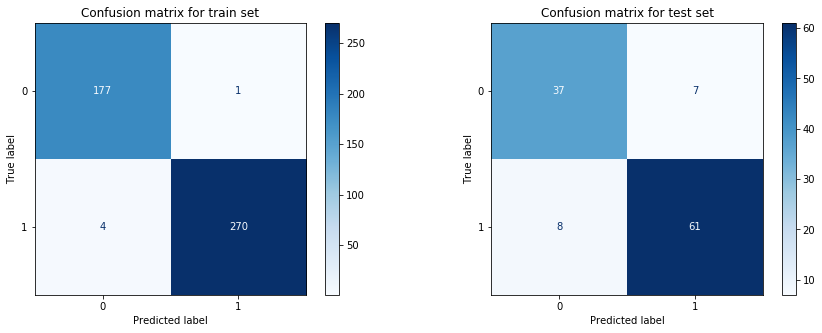

In [72]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf_RF_pca, new_Xtrain, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf_RF_pca, new_Xtest, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Now let's observe the performance with Non-linear SVM:

In [65]:
clf_SVC_pca = SVC(C=100, kernel='rbf', class_weight='balanced',gamma='auto',probability=True).fit(new_Xtrain,bin_ytrain)

df_scores.loc['Non-linear SVM, on train'] = report_performance(clf_SVC_pca,new_Xtrain, bin_ytrain, type_decision='predict_proba')
df_scores.loc['Non-linear SVM, on test'] = report_performance(clf_SVC_pca,new_Xtest, bin_ytest, type_decision='predict_proba')
df_scores.iloc[4:6]

,F1 score,Accuracy,ROC AUC,Log loss
"Non-linear SVM, on train",0.94717,0.938053,0.982326,0.2481
"Non-linear SVM, on test",0.932331,0.920354,0.9417,0.367149


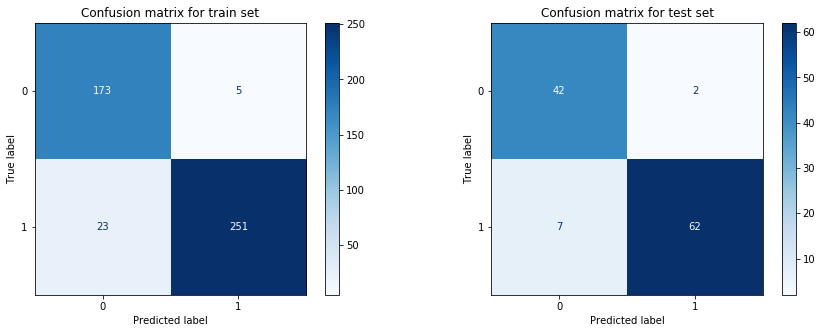

In [73]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf_SVC_pca, new_Xtrain, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf_SVC_pca, new_Xtest, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Now let's observe the ROC curves for all the classifiers, on test and train, for those principal components:

<Figure size 432x288 with 0 Axes>

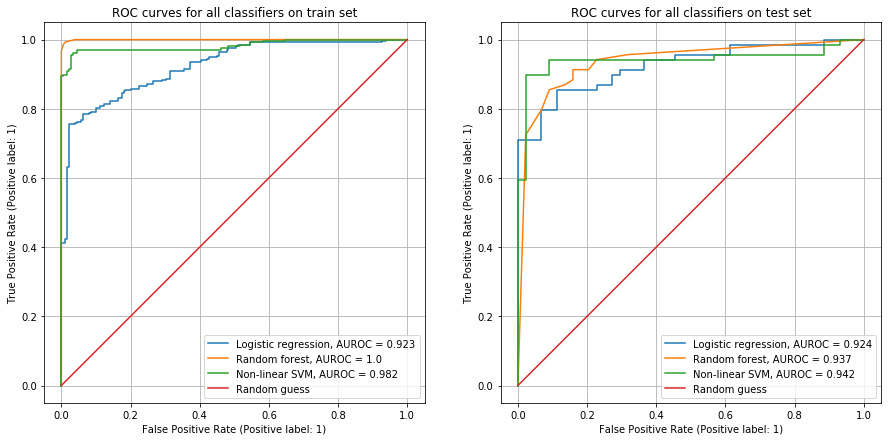

In [66]:
classifiers = [clf_LR, clf_RF_pca,clf_SVC_pca]
roc_score = []
plt.figure()
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
for clfr in classifiers:
    plot_roc_curve(clfr, new_Xtrain, bin_ytrain, ax=ax[0])
    roc_score.append(np.round_(roc_auc_score(bin_ytrain, clfr.predict_proba(new_Xtrain)[:,1]), decimals=3))
ax[0].plot(np.linspace(0,1,new_Xtrain.shape[0]),np.linspace(0,1,new_Xtrain.shape[0]))
ax[0].legend(('Logistic regression, AUROC = '+str(roc_score[0]),'Random forest, AUROC = '+str(roc_score[1]),'Non-linear SVM, AUROC = '+str(roc_score[2]), 'Random guess'))
ax[0].grid()
ax[0].set_title('ROC curves for all classifiers on train set')

roc_score = []
for clfr in classifiers:
    plot_roc_curve(clfr, new_Xtest, bin_ytest, ax=ax[1])
    roc_score.append(np.round_(roc_auc_score(bin_ytest, clfr.predict_proba(new_Xtest)[:,1]), decimals=3))
ax[1].plot(np.linspace(0,1,new_Xtest.shape[0]),np.linspace(0,1,new_Xtest.shape[0]))
ax[1].legend(('Logistic regression, AUROC = '+str(roc_score[0]),'Random forest, AUROC = '+str(roc_score[1]),'Non-linear SVM, AUROC = '+str(roc_score[2]), 'Random guess'))
ax[1].grid()
ax[1].set_title('ROC curves for all classifiers on test set')

plt.show()

Now we'll do the same with the best two features of section 6:

We will start with Logistic regression:

In [67]:
Xtrain_2best = bin_Xtrain.loc[:, [Imp_ft1, Imp_ft2]]
Xtest_2best = bin_Xtest.loc[:, [Imp_ft1, Imp_ft2]]
clf_LR_2 = LogisticRegression(solver='saga',penalty=best_params_LR['penalty'], C=best_params_LR['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(Xtrain_2best,bin_ytrain)

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test',
           'Non-linear SVM, on train', 'Non-linear SVM, on test']
df_scores_2best = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores_2best.loc['Logistic Regression, on train'] = report_performance(clf_LR_2,Xtrain_2best, bin_ytrain)
df_scores_2best.loc['Logistic Regression, on test'] = report_performance(clf_LR_2,Xtest_2best, bin_ytest)
df_scores_2best.head(2)

,F1 score,Accuracy,ROC AUC,Log loss
"Logistic Regression, on train",0.883117,0.860619,0.907273,3.80395
"Logistic Regression, on test",0.866142,0.849558,0.881752,4.9376


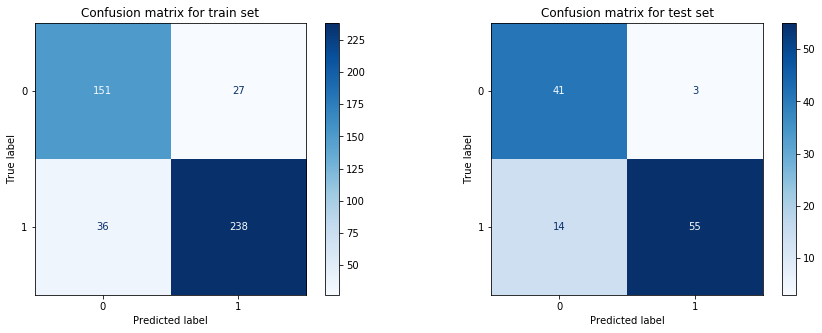

In [74]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf_LR_2, Xtrain_2best, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf_LR_2, Xtest_2best, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Now let's observe the performance with Random forest:

In [68]:
clf_RF_2 = RandomForestClassifier(class_weight='balanced', n_estimators=best_params_RF['Nb_trees'],
                             criterion=best_params_RF['Criterion'], max_features=2, 
                             oob_score=best_params_RF['oob_score']).fit(Xtrain_2best,bin_ytrain)

df_scores_2best.loc['Random Forest, on train'] = report_performance(clf_RF_2,Xtrain_2best, bin_ytrain, type_decision='predict_proba')
df_scores_2best.loc['Random Forest, on test'] = report_performance(clf_RF_2,Xtest_2best, bin_ytest, type_decision='predict_proba')
df_scores_2best.iloc[2:4]

,F1 score,Accuracy,ROC AUC,Log loss
"Random Forest, on train",0.883117,0.860619,0.907273,0.33699
"Random Forest, on test",0.866142,0.849558,0.881752,0.400028


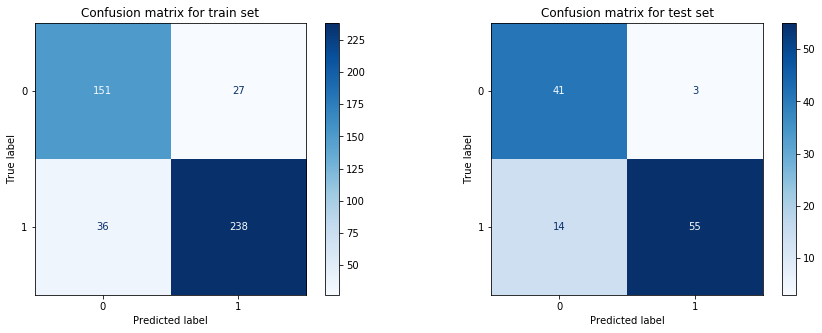

In [75]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf_RF_2, Xtrain_2best, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf_RF_2, Xtest_2best, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Now let's observe the performance with Non-linear SVM:

In [69]:
clf_SVC_2 = SVC(C=100, kernel='rbf', class_weight='balanced',gamma='auto',probability=True).fit(Xtrain_2best,bin_ytrain)

df_scores_2best.loc['Non-linear SVM, on train'] = report_performance(clf_SVC_2,Xtrain_2best, bin_ytrain, type_decision='predict_proba')
df_scores_2best.loc['Non-linear SVM, on test'] = report_performance(clf_SVC_2,Xtest_2best, bin_ytest, type_decision='predict_proba')
df_scores.iloc[4:6]

,F1 score,Accuracy,ROC AUC,Log loss
"Non-linear SVM, on train",0.94717,0.938053,0.982326,0.2481
"Non-linear SVM, on test",0.932331,0.920354,0.9417,0.367149


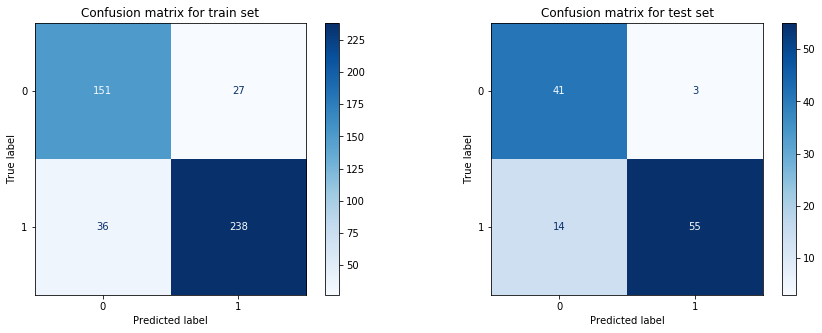

In [76]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=[15,5])
plot_confusion_matrix(clf_SVC_2, Xtrain_2best, bin_ytrain, cmap=plt.cm.Blues, ax=axes[0])
axes[0].set_title('Confusion matrix for train set')
plot_confusion_matrix(clf_SVC_2, Xtest_2best, bin_ytest, cmap=plt.cm.Blues, ax=axes[1])
axes[1].set_title('Confusion matrix for test set')
plt.show()

Now let's observe the ROC curves for all the classifiers, on test and train, for those specific features:

<Figure size 432x288 with 0 Axes>

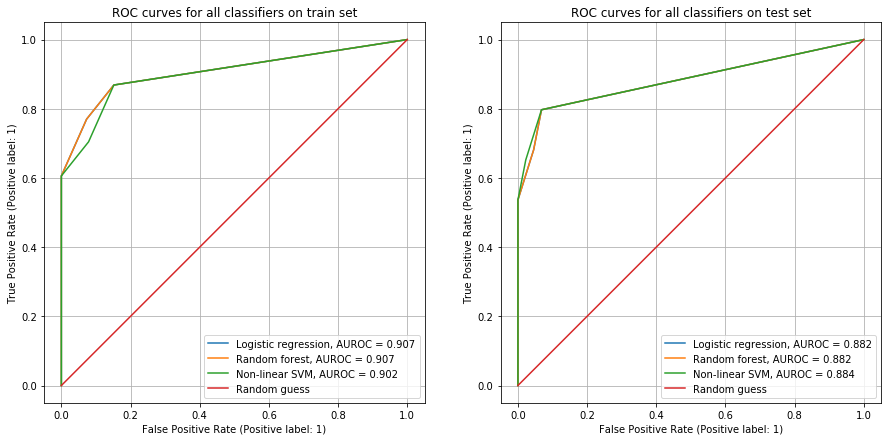

In [77]:
classifiers = [clf_LR_2, clf_RF_2,clf_SVC_2]
roc_score = []
plt.figure()
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,7))
for clfr in classifiers:
    plot_roc_curve(clfr, Xtrain_2best, bin_ytrain, ax=ax[0])
    roc_score.append(np.round_(roc_auc_score(bin_ytrain, clfr.predict_proba(Xtrain_2best)[:,1]), decimals=3))
ax[0].plot(np.linspace(0,1,Xtrain_2best.shape[0]),np.linspace(0,1,Xtrain_2best.shape[0]))
ax[0].legend(('Logistic regression, AUROC = '+str(roc_score[0]),'Random forest, AUROC = '+str(roc_score[1]),'Non-linear SVM, AUROC = '+str(roc_score[2]), 'Random guess'))
ax[0].grid()
ax[0].set_title('ROC curves for all classifiers on train set')

roc_score = []
for clfr in classifiers:
    plot_roc_curve(clfr, Xtest_2best, bin_ytest, ax=ax[1])
    roc_score.append(np.round_(roc_auc_score(bin_ytest, clfr.predict_proba(Xtest_2best)[:,1]), decimals=3))
ax[1].plot(np.linspace(0,1,Xtest_2best.shape[0]),np.linspace(0,1,Xtest_2best.shape[0]))
ax[1].legend(('Logistic regression, AUROC = '+str(roc_score[0]),'Random forest, AUROC = '+str(roc_score[1]),'Non-linear SVM, AUROC = '+str(roc_score[2]), 'Random guess'))
ax[1].grid()
ax[1].set_title('ROC curves for all classifiers on test set')

plt.show()

Let's print the results of all the classifiers, on train and test, using the two different methods above:

In [28]:
print('Performance scores for the 2 most important features: \n')
df_scores_2best.head(6)

Performance scores for the 2 most important features: 



,F1 score,Accuracy,ROC AUC,Log loss
"Logistic Regression, on train",0.883117,0.860619,0.907273,3.80396
"Logistic Regression, on test",0.866142,0.849558,0.881752,4.93762
"Random Forest, on train",0.883117,0.860619,0.907273,0.340754
"Random Forest, on test",0.866142,0.849558,0.881752,0.407503
"Non-linear SVM, on train",0.883117,0.860619,0.901552,0.362812
"Non-linear SVM, on test",0.866142,0.849558,0.883729,0.379901


In [29]:
print('\nPerformance scores for the 2 principal components using PCA: \n')
df_scores.head(6)


Performance scores for the 2 principal components using PCA: 



,F1 score,Accuracy,ROC AUC,Log loss
"Logistic Regression, on train",0.852273,0.827434,0.92346,4.1262
"Logistic Regression, on test",0.861538,0.840708,0.924242,4.08418
"Random Forest, on train",0.996337,0.995575,0.999959,0.0488843
"Random Forest, on test",0.874074,0.849558,0.940711,1.40296
"Non-linear SVM, on train",0.94717,0.938053,0.982326,0.251608
"Non-linear SVM, on test",0.932331,0.920354,0.9417,0.366229


As we can notice, the two principal components given by dimensionality reduction (PCA) give better performance scores for non-linear models (F1 score of 93.2% for non-linear SVM), whereas the two most important features give better results for the linear model (logistic regression). Overall, non-linear models remain the best option for our problem, specially non-linear SVM.

![Folks](https://i.pinimg.com/originals/8f/31/96/8f31964f2eebfa559fd5bf413a65e3e3.jpg)